In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, auc, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

To Do List: 

1. Compare model with and without the cycle indicator using both Penalized Logistic Regression and Gradient Boosting 
2. Metrics used for Model Comparison: ROC and AUC

# Functions

In [2]:

def get_numpy_data(dataframe, features, label):
    features_matrix = dataframe[features].to_numpy()
    label_array = dataframe[label].to_numpy()
    return  features_matrix, label_array

In [3]:
def data_import(file_path, list_to_drop, test_size, random_state):
    
    data = pd.read_csv(file_path).drop(list_to_drop, axis = 1)
    #data["spread_derivative"] = pd.to_numeric(data["spread_derivative"], errors = "coerce")
    data.replace([np.inf, -np.inf], np.nan, inplace = True)
    data = data.dropna()
    
    feature_list = data.columns.to_list()
    feature_list.remove("custom_recession_data")
    recession_label = "custom_recession_data"
    print("Final dataset contains the following features: " + str(feature_list))
    
    feature_matrix, label_array = get_numpy_data(data, feature_list, recession_label)
    x_train, x_test, y_train, y_test = train_test_split(feature_matrix, label_array, test_size = test_size, random_state = random_state)
    return x_train, x_test, y_train, y_test
    

# Data Import

1. Recession Data __with__ Volatility Index and Cycle Indicator (Vix/Spread)

In [10]:
file_path = "final_data/updated_final_data_90.csv"
columns_to_drop = ["Unnamed: 0", "date", "indpro", "m2v", "umcsent", "usrecd", "m1sl", "m2sl", "icsa", "mabmm301usm189s",  "bogmbase", "volume", "adj close", "cycle_indicator",'spread_derivative', 'spread_change_momentun']
test_size = 0.3
random_state = 11

x_train_vix, x_test_vix, y_train_vix, y_test_vix = data_import(file_path, columns_to_drop, test_size, random_state)

Final dataset contains the following features: ['final_vol', 'tcu', 'cpiaucsl_x', 'fedfunds', 'dff', 'civpart', 'unrate', 'mich', 't10y3m']


In [11]:
x_train_vix.shape

(338, 9)

# Logistic Regression with L2 Penalty

In [23]:
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, StandardScaler
from sklearn.pipeline import Pipeline as pipe
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

In [5]:
# Logistic Regression Pipe
lr_pipe = pipe([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures()),
    ("model", LogisticRegression(max_iter = 2000, solver = "liblinear", random_state = 0))
])

In [6]:
# Logistic Regression Grid Search
lr_param_grid = [{"model__penalty": ['l1', 'l2'],
                  "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
                  "model__fit_intercept": [True, False],
                  "model__class_weight": [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}],
                  "polynomial__degree": [1, 2, 3]}]

In [7]:
# Grid Search
lr_grid_search = GridSearchCV(estimator=lr_pipe,
        param_grid=lr_param_grid,
        scoring='roc_auc',
        cv=6)

## Logistic Regression for Data with VIX and Cycle Indicator

1. Grid Search for Hyperparameter Tuning

In [12]:
lr_grid_search.fit(x_train_vix, y_train_vix)
df = pd.DataFrame(lr_grid_search.cv_results_)
df[df["rank_test_score"] == 1]
# Evaluate on the test set using the best parametersb


C:\Users\peter\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_model__fit_intercept,param_model__penalty,param_polynomial__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
113,0.014247,0.000741,0.00092,0.000451,1,"{0: 1, 1: 1}",True,l2,3,"{'model__C': 1, 'model__class_weight': {0: 1, ...",0.997143,0.988571,0.99,1.0,0.947522,0.938776,0.977002,0.024385,1


In [13]:
print("Best Parameters: ", lr_grid_search.best_params_)
print("Best AUC-ROC: {:.2f}".format(lr_grid_search.best_score_))

# Evaluate on the test set using the best parameters
best_model = lr_grid_search.best_estimator_
test_auc_roc = lr_grid_search.score(x_test_vix, y_test_vix)
print("Test AUC-ROC: {:.2f}".format(test_auc_roc))

Best Parameters:  {'model__C': 1, 'model__class_weight': {0: 1, 1: 1}, 'model__fit_intercept': True, 'model__penalty': 'l2', 'polynomial__degree': 3}
Best AUC-ROC: 0.98
Test AUC-ROC: 0.95


2. Creating the Logistic Regression using the Grid Search Results

In [71]:
log_pipe_vix = pipe([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(3)),
    ("model", LogisticRegression(random_state = 0, class_weight = {0: 1, 1: 1}, penalty = "l2", C = 1, fit_intercept = True, solver = "liblinear", max_iter = 2000))
])

3. Logistic Regression Results on Test-Set

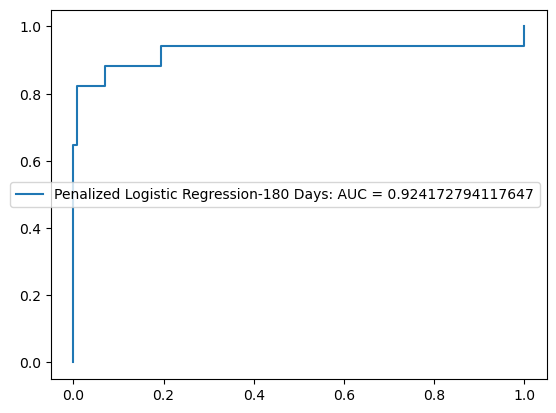

In [58]:
prob = log_pipe_vix.fit(x_train_vix, y_train_vix).predict_proba(x_test_vix)
pred = log_pipe_vix.fit(x_train_vix, y_train_vix).predict(x_test_vix)
fpr_log_vix, tpr_log_vix, thresholds = roc_curve(y_test_vix, prob[:, 1], pos_label=1)
auc_log_vix = auc(fpr_log_vix, tpr_log_vix)
plt.plot(fpr_log_vix, tpr_log_vix, label = "Penalized Logistic Regression-180 Days: AUC = " + str(auc_log_vix))
plt.legend()

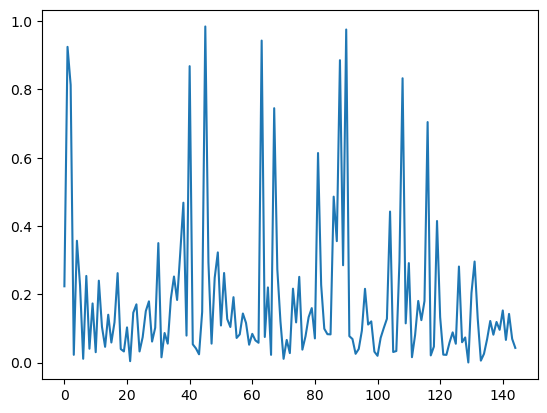

In [59]:
plt.plot(prob[:,1])

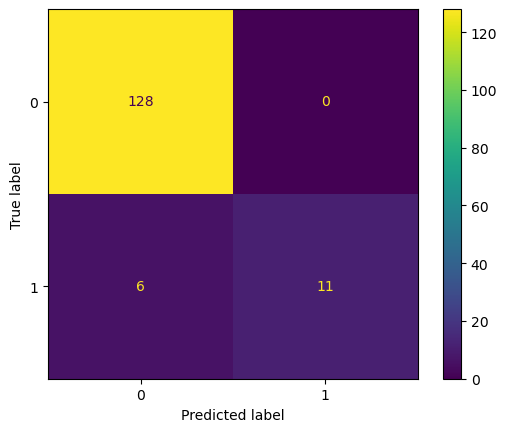

In [60]:
cm = confusion_matrix(y_test_vix, pred)
ConfusionMatrixDisplay(cm).plot()

# Gradient Boosting 

In [17]:
pipe = pipe([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures()),
    ("model", GradientBoostingClassifier(random_state = 0))
])

In [18]:
# Logistic Regression Grid Search
lr_param_grid = [{'model__n_estimators': [10, 50, 100, 200],
                   "model__learning_rate": [ 0.01, 0.1, 0.5, 1],
                   'model__max_depth': [1, 3, 5],
                  "model__min_samples_split": [2, 5, 10],
                  "model__subsample": [0.7, 1],
                 'polynomial__degree': [1]}]

In [19]:
# Grid Search
lr_grid_search = GridSearchCV(estimator=pipe,
        param_grid=lr_param_grid,
        scoring='roc_auc',
        cv=6)

## Gradient Boosting for Data with VIX and Cycle Indicator

In [20]:
lr_grid_search.fit(x_train_vix, y_train_vix)
df = pd.DataFrame(lr_grid_search.cv_results_)
df[df["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__min_samples_split,param_model__n_estimators,param_model__subsample,param_polynomial__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
135,0.303309,0.003297,0.001331,0.00047,0.1,5,5,200,1,1,"{'model__learning_rate': 0.1, 'model__max_dept...",0.985714,0.994286,0.953333,0.98,0.982507,0.959184,0.975837,0.014626,1


In [21]:
print("Best Parameters: ", lr_grid_search.best_params_)
print("Best AUC-ROC: {:.2f}".format(lr_grid_search.best_score_))

# Evaluate on the test set using the best parameters
best_model = lr_grid_search.best_estimator_
test_auc_roc = lr_grid_search.score(x_test_vix, y_test_vix)
print("Test AUC-ROC: {:.2f}".format(test_auc_roc))

Best Parameters:  {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200, 'model__subsample': 1, 'polynomial__degree': 1}
Best AUC-ROC: 0.98
Test AUC-ROC: 0.98


In [72]:
gbm_pipe = pipe([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, min_samples_split = 5, n_estimators = 200, subsample = 1, random_state = 0))
])

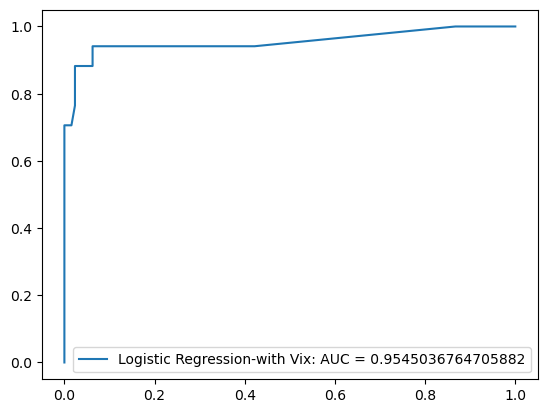

In [68]:
prob = gbm_pipe.fit(x_train_vix, y_train_vix).predict_proba(x_test_vix)
pred = gbm_pipe.fit(x_train_vix, y_train_vix).predict(x_test_vix)
fpr_gbm_vix, tpr_gbm_vix, thresholds = roc_curve(y_test_vix, prob[:, 1], pos_label=1)
auc_gbm_vix = auc(fpr_gbm_vix, tpr_gbm_vix)
plt.plot(fpr_gbm_vix, tpr_gbm_vix, label = "Logistic Regression-with Vix: AUC = " + str(auc_gbm_vix))
plt.legend()

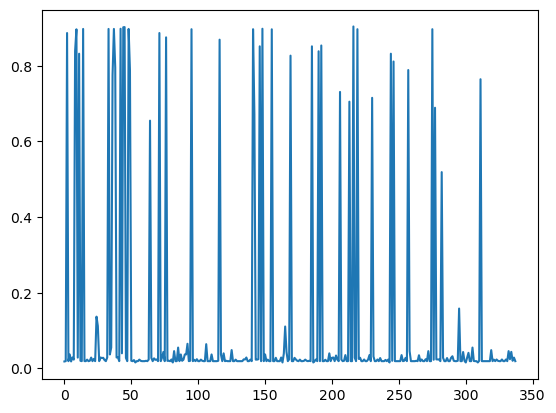

In [69]:
prob = gbm_pipe.fit(x_train_vix, y_train_vix).predict_proba(x_train_vix)
plt.plot(prob[:,1])

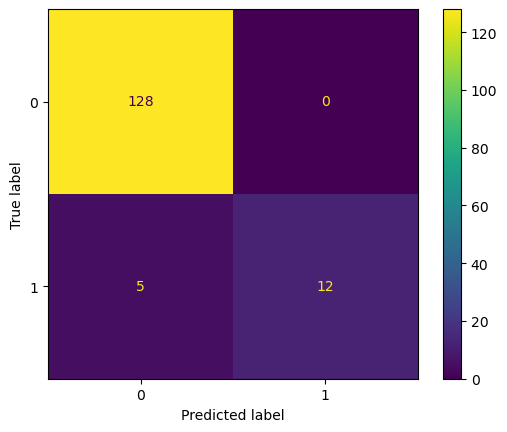

In [70]:
cm = confusion_matrix(y_test_vix, pred)
ConfusionMatrixDisplay(cm).plot()

# Model Performance Comparison

Text(0, 0.5, 'True Positive Rate')

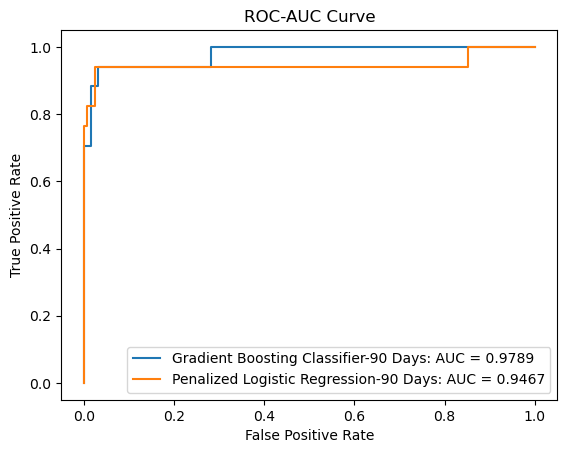

In [33]:
fig, ax = plt.subplots()

ax.plot(fpr_gbm_vix, tpr_gbm_vix, label = "Gradient Boosting Classifier-90 Days: AUC = " + str(round(auc_gbm_vix, 4)))
ax.plot(fpr_log_vix, tpr_log_vix, label = "Penalized Logistic Regression-90 Days: AUC = " + str(round(auc_log_vix, 4)))
ax.legend()
ax.set_title("ROC-AUC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")